# Datenvorbereitung_Kurvenfahrt
#### Socken- (Schuh-) Daten in geeignetes Format bringen
... um trainierte Netzwerke mit geeigneten Daten zu "füttern".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import tensorflow as tf
import seaborn as sns

sns.set_style("whitegrid")
current_palette = sns.color_palette()

## Sockendaten...

In [2]:
sock_data = pd.read_csv('Klassifizierung_Daten/sockeversuch7.txt',delimiter='\t', header=0) #Versuchsdaten zum Kurvenfahrtenversuch
#sock_data
#sock_data.shape

#### Berücksichtige nur Daten zwischen erstem und letztem Trigger:

In [3]:
#Finde Triggerpunkte
x = sock_data.Trigger
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
trig=get_indexes(1,x)
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
sock_data=sock_data.drop(sock_data.index[range(max(trig)+1,len(sock_data.index))])
sock_data=sock_data.drop(sock_data.index[range(0,min(trig))])

#### Setze den Millisekunden(ms)-Startwert des Dataframes (df) auf Null

In [4]:
sock_data=sock_data.rename(columns={"Milisec": "ms"})
sock_data.ms = (sock_data.ms-sock_data.ms[min(trig)])
#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data.index = pd.TimedeltaIndex(sock_data.ms,  unit='ms')
sock_data = sock_data.drop(columns="Time") #Time ein tf-object das nicht mehr benötigt wird

#### Upsamling der Daten:

In [5]:
sock_data1 = sock_data.resample('50L').asfreq() #upsampling: '50L' entspricht 50ms
sock_data2 = sock_data1.interpolate(method='linear') #interpolieren um NaN-Einträge zu füllen

In [6]:
#letzte Zeile fallen lassen --> damit gleiche Länge wie Daten aus Matlab
sock_data2 = sock_data2[:-1]

In [7]:
sock_data2 = sock_data2.drop(['ms', 'M1A6', 'M2A6'], axis=1)
sock_data3 = sock_data2.drop(columns='Trigger')    #sock_data3 enthält nur noch Sensordaten aller 20 Sensoren der Socke, shape(None,20)

#### Beispielplot

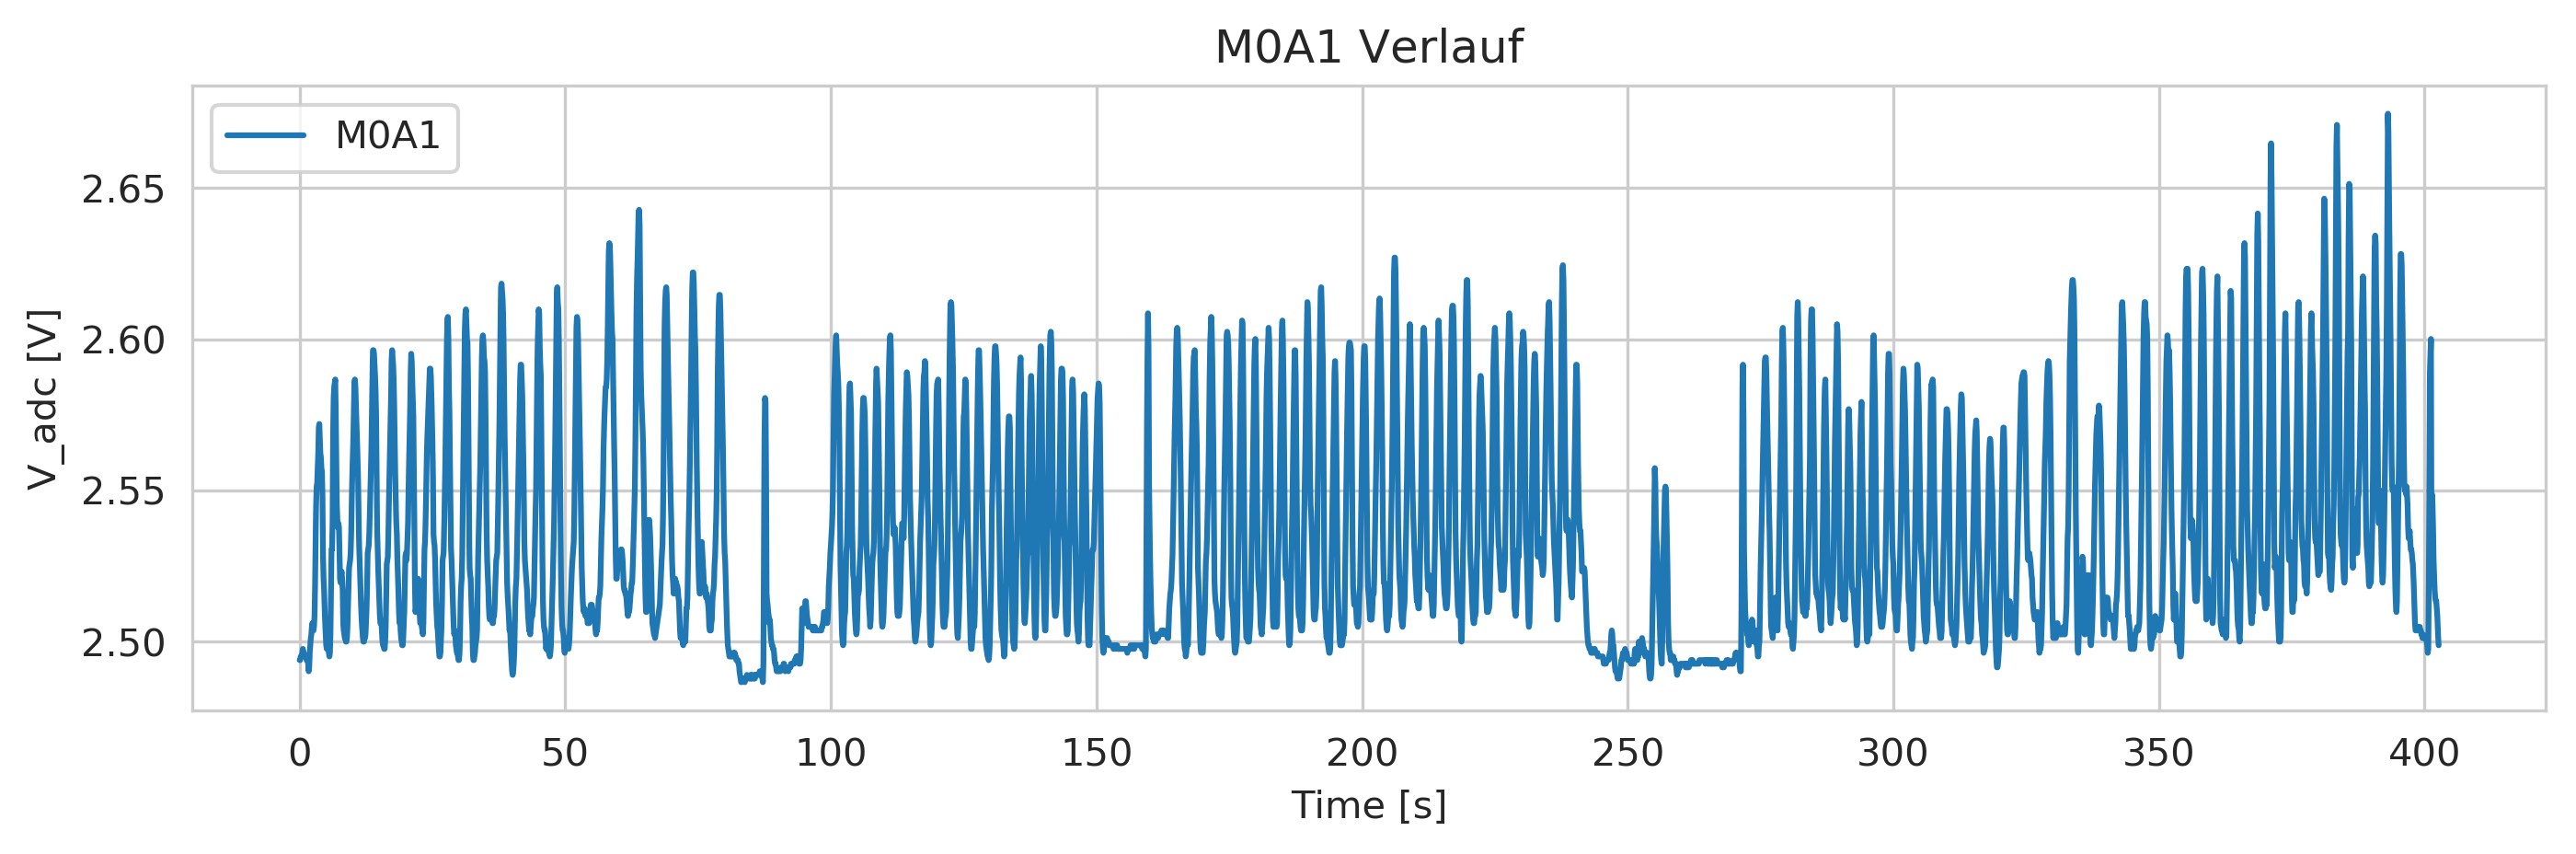

In [8]:
plt.figure(num=None, figsize=(11, 3), dpi=300, facecolor='w', edgecolor='k'),
x = np.linspace(start=0,stop=(len(sock_data3)*.05-.05),num=len(sock_data3))
plt.plot(x, sock_data3['M0A1'], label='M0A1')
plt.xlabel('Time [s]')
plt.ylabel('V_adc [V]')
plt.title("M0A1 Verlauf")
plt.legend()
plt.show()

#### Aufteilen der Daten in Trainings und in Testdaten:
    x_train    y_train                  64%
    x_val      y_val                    16%
    x_test     y_test                   20%

In [9]:
train = 0.64
val = 0.16
test = 0.20
test_len = len(sock_data3)*test

Auswahl eines Zeitintervals in dem alle Label auftreten für Testdaten.

        Test Daten für ca. 80 s ab 150 s
Ausschneiden und einfügen dieser Testdaten ans Ende der Datenreihe

In [10]:
cut1 = int(150/0.05)
cut2 = int(test_len+cut1)

In [11]:
sock_data3_first_second = sock_data3.iloc[:cut2]
sock_data3_first = sock_data3_first_second.iloc[:cut1]
sock_data3_second = sock_data3_first_second.iloc[cut1:]
sock_data_third = sock_data3.iloc[cut2:]
sock_data4 = sock_data_third.append(sock_data3_first, ignore_index=True)
sock_data4 = sock_data4.append(sock_data3_second, ignore_index=True)

In [12]:
idx_val = round(train*len(sock_data4))
#idx_val = int(idx_val/batchsize)*batchsize
idx_test = round((train+val)*len(sock_data4))
x_train_val = sock_data4[:idx_test]
x_test0 = sock_data4[idx_test:]

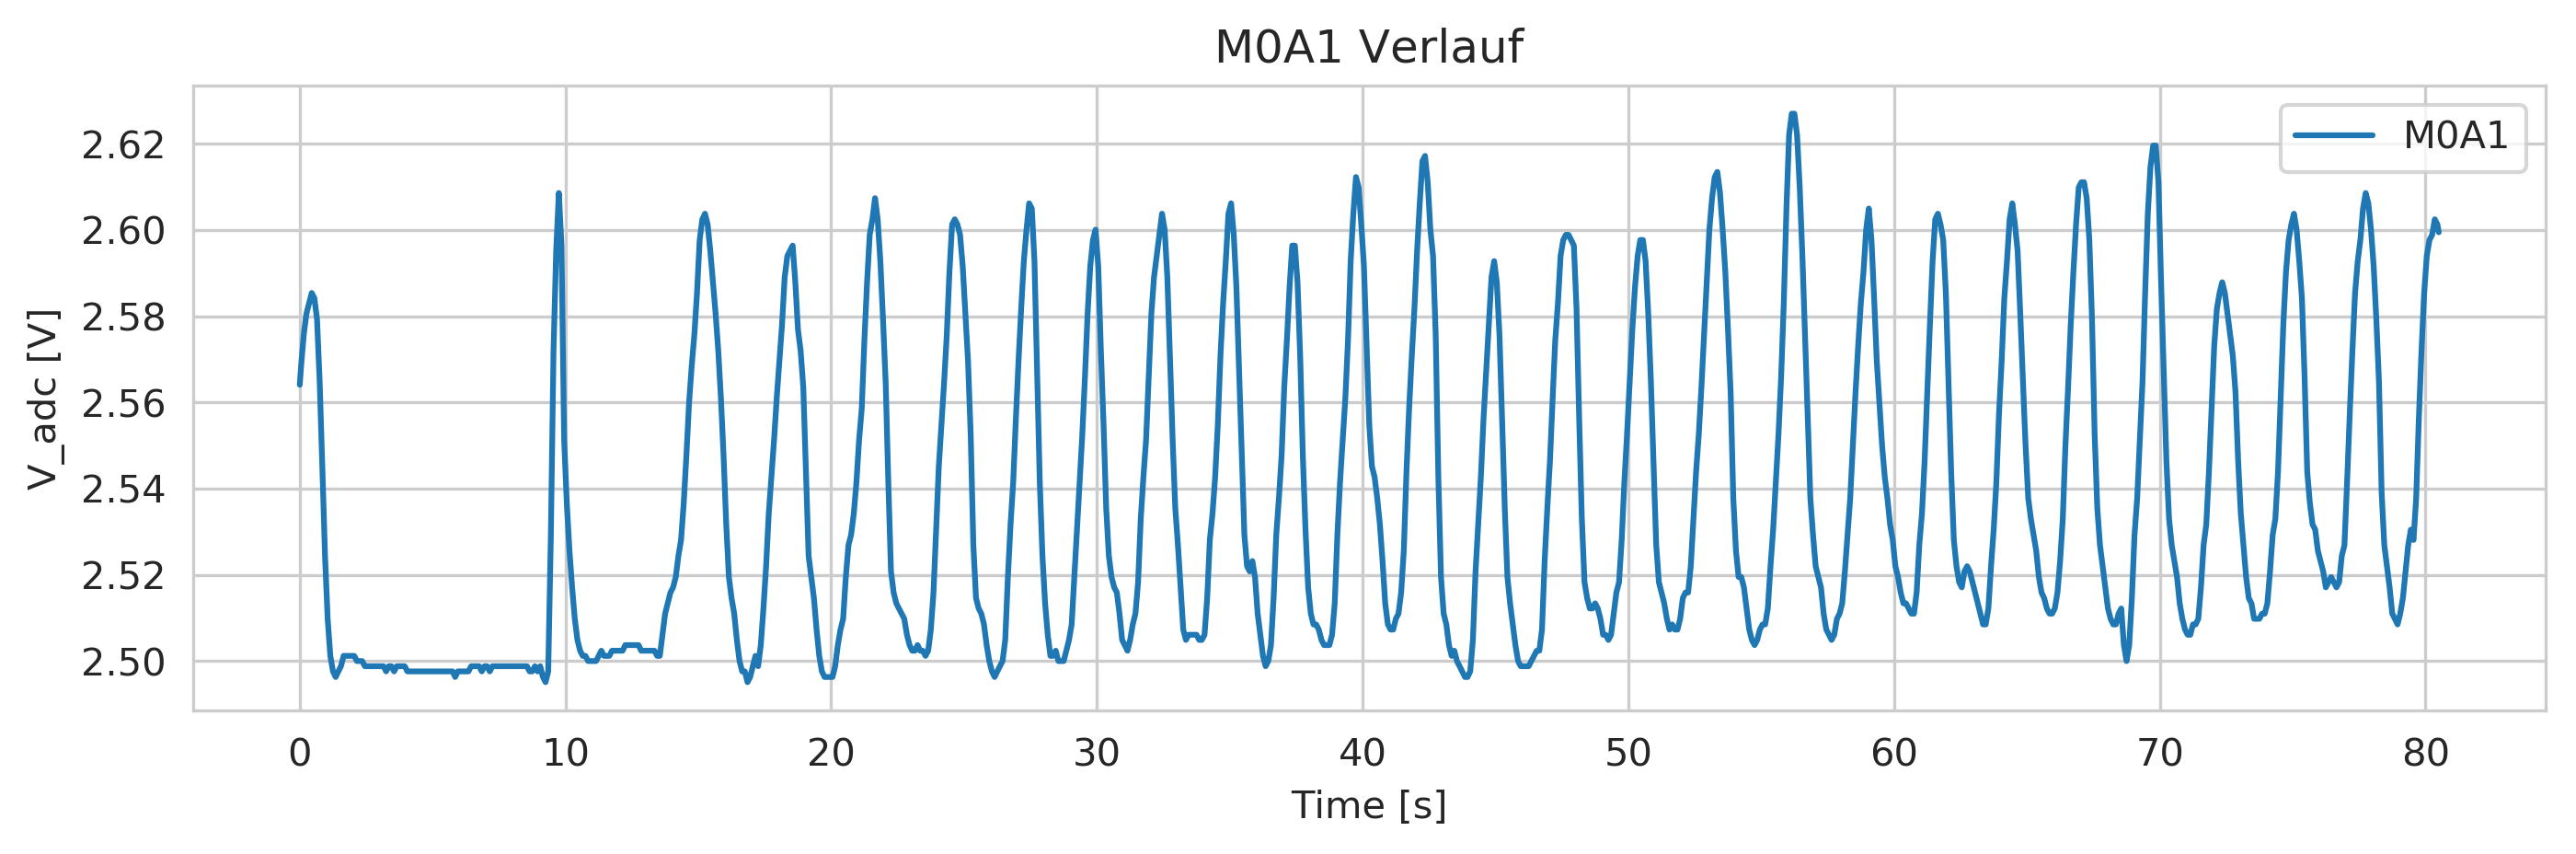

In [13]:
plt.figure(num=None, figsize=(11, 3), dpi=300, facecolor='w', edgecolor='k'),
x = np.linspace(start=0,stop=(len(x_test0)*.05-.05),num=len(x_test0))
plt.plot(x, x_test0['M0A1'], label='M0A1')
plt.xlabel('Time [s]')
plt.ylabel('V_adc [V]')
plt.title("M0A1 Verlauf")
plt.legend()
plt.show()

In [14]:
sock_data4.shape

(8054, 20)

#### Normierung der Daten

In [15]:
# wird anhand Trainings- und Validierungsdaten normiert. Nicht anhand Testdaten - diese Werden mit Wert aus Trainings- und Validierungsdaten-resultierenden mean-& std-Werten normiert
mean = x_train_val.mean(axis=0)
x_train_val -= mean
std = x_train_val.std(axis=0)
x_train_val /= std
x_test0 -= mean #muss mit gleichen mean/std-Werten geschehen
x_test0 -= std  #--"--

Teilen der Trainings- und Validierungsdaten

In [16]:
x_train0 = x_train_val[:idx_val]
x_val0 = x_train_val[idx_val:]

In [17]:
x_train0.shape, x_val0.shape, x_test0.shape

((5155, 20), (1288, 20), (1611, 20))

#### Reshaping...
... zu Format (samples, timesteps, features)

In [18]:
samples = None
timesteps = 22 #Auf 22 sek festgelegt (22*0.05s = 1.1s) ; ungleich 20 um von features.shape unterscheiden zu können 
features = len(x_train0.columns) #Anzahl der Sensoren
step = 1 #Versatz zum nächsten Sample; ungerade damit Interpolierte und urspüngliche Werte abwechselnd in die jeweilige LSTM-Zelle eingehen.
batchsize = 128

In [19]:
# zum Reshaping benötigte Indizes
a = int(((len(x_train0))-timesteps)/step)
b = int(((len(x_val0))-timesteps)/step)
c = int(((len(x_test0))-timesteps)/step)

In [20]:
# Reshaping Trainingsdaten
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
x_train = np.ndarray((1,timesteps,features))
x_train.fill(0)

for i in range(a):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = x_train0.iloc[(j+i*step),k]
    x_train = np.concatenate((x_train,temp), axis=0)
x_train = x_train[1:]

In [21]:
# Reshaping Validierungsdaten
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
x_val = np.ndarray((1,timesteps,features))
x_val.fill(0)

for i in range(b):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = x_val0.iloc[(j+i*step),k]
    x_val = np.concatenate((x_val,temp), axis=0)
x_val = x_val[1:]

In [22]:
# Reshaping Testdaten
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
x_test = np.ndarray((1,timesteps,features))
x_test.fill(0)

for i in range(c):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = x_test0.iloc[(j+i*step),k]
    x_test = np.concatenate((x_test,temp), axis=0)
x_test = x_test[1:]           

In [23]:
# letzte Werte, die nicht mehr in ein kompletten Batch passen fallen lassen --> damit kein "Padding" benötigt wird
x_train = x_train[:int(x_train.shape[0]/batchsize)*batchsize]
x_val = x_val[:int(x_val.shape[0]/batchsize)*batchsize]
x_test = x_test[:int(x_test.shape[0]/batchsize)*batchsize]

In [24]:
x_train.shape, x_val.shape, x_test.shape

((5120, 22, 20), (1152, 22, 20), (1536, 22, 20))

## Daten Kurvenfahrt - 4 Label

Y-Daten Kurvenfahrt

In [25]:
import scipy.io
from keras.utils import np_utils

Using TensorFlow backend.


In [26]:
#importiere gelabelte Kurvenfahrtendaten von Matlabfile
mat = scipy.io.loadmat('Klassifizierung_Daten/yKurven4Label.mat')
yKurven=mat['ydata']
yKurven.shape

(1, 8054)

##### yKurven Label:
    0: keine Kurvenfahrt bzw. Kurvenwechsel
    1: Kurvenwechsel (von rechts nach links, oder umgekehrt)
    2: Linkskurve
    3: Rechtskurve

One-Hot codierte Label:

In [27]:
Y_Kurven_all = np.squeeze(np_utils.to_categorical(yKurven), axis=0)

In [28]:
Y_Kurven_all.shape

(8054, 4)

In [29]:
x.shape

(1611,)

Beispielplot:

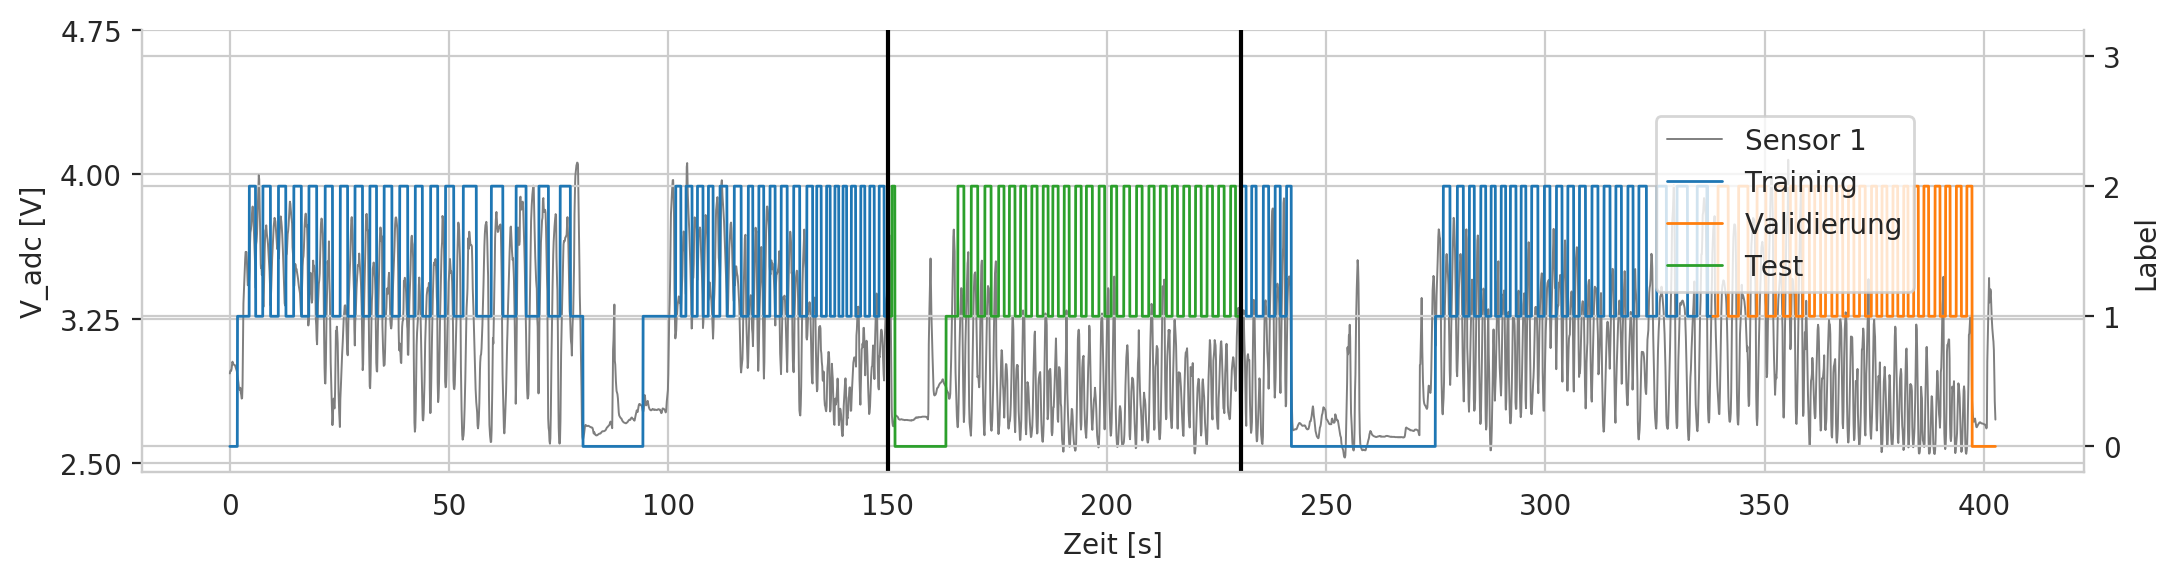

In [69]:
train_end = cut2+int(len(Y_Kurven_all)*0.64)-cut1
f, ax1 = plt.subplots(figsize=(11, 3), dpi=200, facecolor='w', edgecolor='k')
x = np.linspace(start=0,stop=(len(sock_data3)*.05-.05),num=len(sock_data3))
x1 = np.linspace(start=0,stop=(cut1*.05-.05),num=cut1)
x1_1 = np.linspace(start=cut2*.05,stop=(train_end*.05-.05),num=(train_end-cut2))
x2 = np.linspace(start=train_end*.05,stop=(len(Y_Kurven_all)*.05-.05),num=(len(Y_Kurven_all)-train_end))
x3 = np.linspace(start=3000*.05,stop=(4610*.05-.05),num=4610-3000)
ax1.plot(x, sock_data3['M0A0'],color=current_palette[7], label='Sensor 1',linewidth=0.7, mew=0.1)
ax1.set_xlabel('Zeit [s]')
ax1.set_ylabel('V_adc [V]')
ax1.set(yticks=([2.5,3.25,4.0,4.75]) )
ax2 = ax1.twinx()
ax2.plot(x1, np.transpose(yKurven)[0:cut1],color=current_palette[0], label='Training',linewidth=1, mew=0.1)
ax2.plot(x1_1, np.transpose(yKurven)[cut2:train_end],color=current_palette[0],linewidth=1, mew=0.1)
ax2.plot(x2, np.transpose(yKurven)[train_end:len(Y_Kurven_all)],color=current_palette[1], label='Validierung',linewidth=1, mew=0.1)
ax2.plot(x3, np.transpose(yKurven)[cut1:cut2],color=current_palette[2], label='Test',linewidth=1, mew=0.1)
ax2.set(yticks=([0,1,2,3]) )
ax2.set_ylabel('Label')
ax2.set_ylim(-0.2,3.2)
sns.despine(right=False)
f.legend(loc=7, bbox_to_anchor=(0.3, 0.3, 0.57, 0.65), borderaxespad=0)
plt.axvline(x=cut1*0.05, ymin=0, ymax=1, color='k')
plt.axvline(x=cut2*0.05, ymin=0, ymax=1, color='k')
#plt.xlim(left=0, right=50)
f.tight_layout()
plt.show()

###### Aufteilen der Daten in Trainings und in Testdaten:

    x_train    y_train                  64%
    x_val      y_val                    16%
    x_test     y_test                   20%
    

In [31]:
Y_Kurven_all.shape

(8054, 4)

Auswahl eines Zeitintervals in dem alle Label auftreten für Testdaten.

        Test Daten für ca. 80 s ab 150 s
Ausschneiden und einfügen dieser Testdaten ans Ende der Datenreihe

In [32]:
Y_cut_first_second = Y_Kurven_all[:cut2]
Y_cut_first = Y_cut_first_second[:cut1]
Y_cut_second = Y_cut_first_second[cut1:]
Y_cut_third = Y_Kurven_all[cut2:]

Y_Kurven_all_cut = np.concatenate((Y_cut_third, Y_cut_first, Y_cut_second), axis=0)

In [33]:
Y_Kurven_all_cut.shape

(8054, 4)

In [34]:
y_k_train_val = Y_Kurven_all_cut[:idx_test]
y_k_train0 = y_k_train_val[:idx_val]
y_k_val0 = y_k_train_val[idx_val:]
y_k_test0 = Y_Kurven_all_cut[idx_test:]
#y_k_test0.shape

In [35]:
temp = np.ndarray((1,timesteps,4))
temp.fill(0)
y_k_train = np.ndarray((1,timesteps,4))
y_k_train.fill(0)

for i in range(a):
    for j in range(timesteps):
        for k in range(4):
            temp[0,j,k] = y_k_train0[(j+i*step),k]
    y_k_train = np.concatenate((y_k_train,temp), axis=0)
y_k_train = y_k_train[1:] 

In [36]:
temp = np.ndarray((1,timesteps,4))
temp.fill(0)
y_k_val = np.ndarray((1,timesteps,4))
y_k_val.fill(0)

for i in range(b):
    for j in range(timesteps):
        for k in range(4):
            temp[0,j,k] = y_k_val0[(j+i*step),k]
    y_k_val = np.concatenate((y_k_val,temp), axis=0)
y_k_val = y_k_val[1:] 

In [37]:
temp = np.ndarray((1,timesteps,4))
temp.fill(0)
y_k_test = np.ndarray((1,timesteps,4))
y_k_test.fill(0)

for i in range(c):
    for j in range(timesteps):
        for k in range(4):
            temp[0,j,k] = y_k_test0[(j+i*step),k]
    y_k_test = np.concatenate((y_k_test,temp), axis=0)
y_k_test = y_k_test[1:]  

In [38]:
y_k_train = y_k_train[:(int(y_k_train.shape[0]/batchsize)*batchsize)]
y_k_val = y_k_val[:(int(y_k_val.shape[0]/batchsize)*batchsize)]
y_k_test = y_k_test[:(int(y_k_test.shape[0]/batchsize)*batchsize)]

In [39]:
y_k_train.shape, y_k_val.shape, y_k_test.shape, a, b, c, idx_val, idx_test

((5120, 22, 4), (1152, 22, 4), (1536, 22, 4), 5133, 1266, 1589, 5155, 6443)

#### Abspeichern der Trainings- Validierungs- und Testdaten der Eingabe und der Zeilwerte der KNNs - 4-Label-Variante

In [40]:
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/4Label/x_train', x_train)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/4Label/x_val', x_val)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/4Label/y_k_train', y_k_train)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/4Label/y_k_val', y_k_val)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/4Label/x_test', x_test)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/4Label/y_k_test', y_k_test)

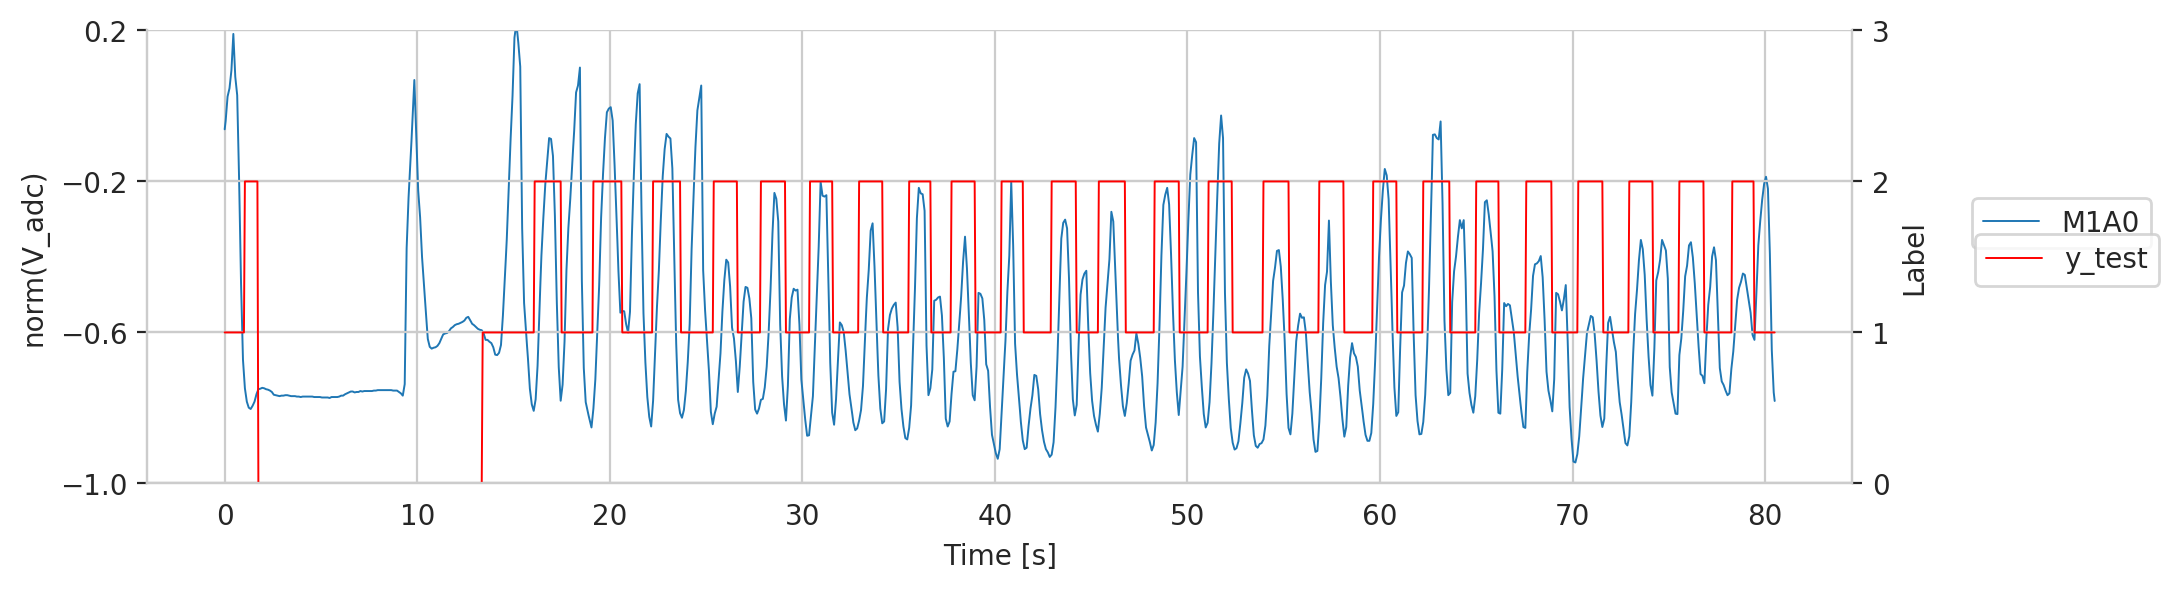

In [68]:
f, ax1 = plt.subplots(figsize=(11, 3), dpi=200, facecolor='w', edgecolor='k')
ax1.plot(np.linspace(0,len(x_test0)-1,len(x_test0))*0.05,x_test0.iloc[:,0], label='M1A0',linewidth=0.7, mew=0.1)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('norm(V_adc)')
ax1.set(yticks=([-1.0,-0.6,-0.2,0.2]) )
ax1.set_ylim(-1,0.2)
ax2 = ax1.twinx()
ax2.plot(np.linspace(0,len(y_k_test0)-1,len(y_k_test0))*0.05,np.argmax(y_k_test0, axis=1),'r', label='y_test',linewidth=0.7, mew=0.1)
ax2.set(yticks=([0,1,2,3]) )
ax2.set_ylabel('Label')
ax1.legend(bbox_to_anchor=(0.6, 0.15, 0.575, 0.48), borderaxespad=0)
ax2.legend(bbox_to_anchor=(0.6, 0.15, 0.58, 0.4), borderaxespad=0)
ax2.set_ylim(0,3)
sns.despine(right=False)
#plt.xlim(left=0, right=500)
plt.show()

In [42]:
np.argmax(y_k_test0, axis=1)

array([3, 3, 3, ..., 3, 3, 3])

In [43]:
y_k_test.shape

(1536, 22, 4)

## Daten Kurvenfahrt - 3 Label

Y-Daten Kurvenfahrt

In [44]:
import scipy.io
from keras.utils import np_utils

In [46]:
#importiere gelabelte Kurvenfahrtendaten
mat = scipy.io.loadmat('Klassifizierung_Daten/yKurven3Label.mat')
yKurven=mat['yKurven3Label']
yKurven.shape

(1, 8054)

##### yKurven Label:
    0: keine Kurvenfahrt bzw. Kurvenwechsel
    1: Kurvenwechsel (von rechts nach links, oder umgekehrt)
    2: Linkskurve
    3: Rechtskurve

One-Hot codierte label:

In [47]:
Y_Kurven_all = np.squeeze(np_utils.to_categorical(yKurven), axis=0)

In [48]:
Y_Kurven_all.shape

(8054, 3)

Beispielplot:

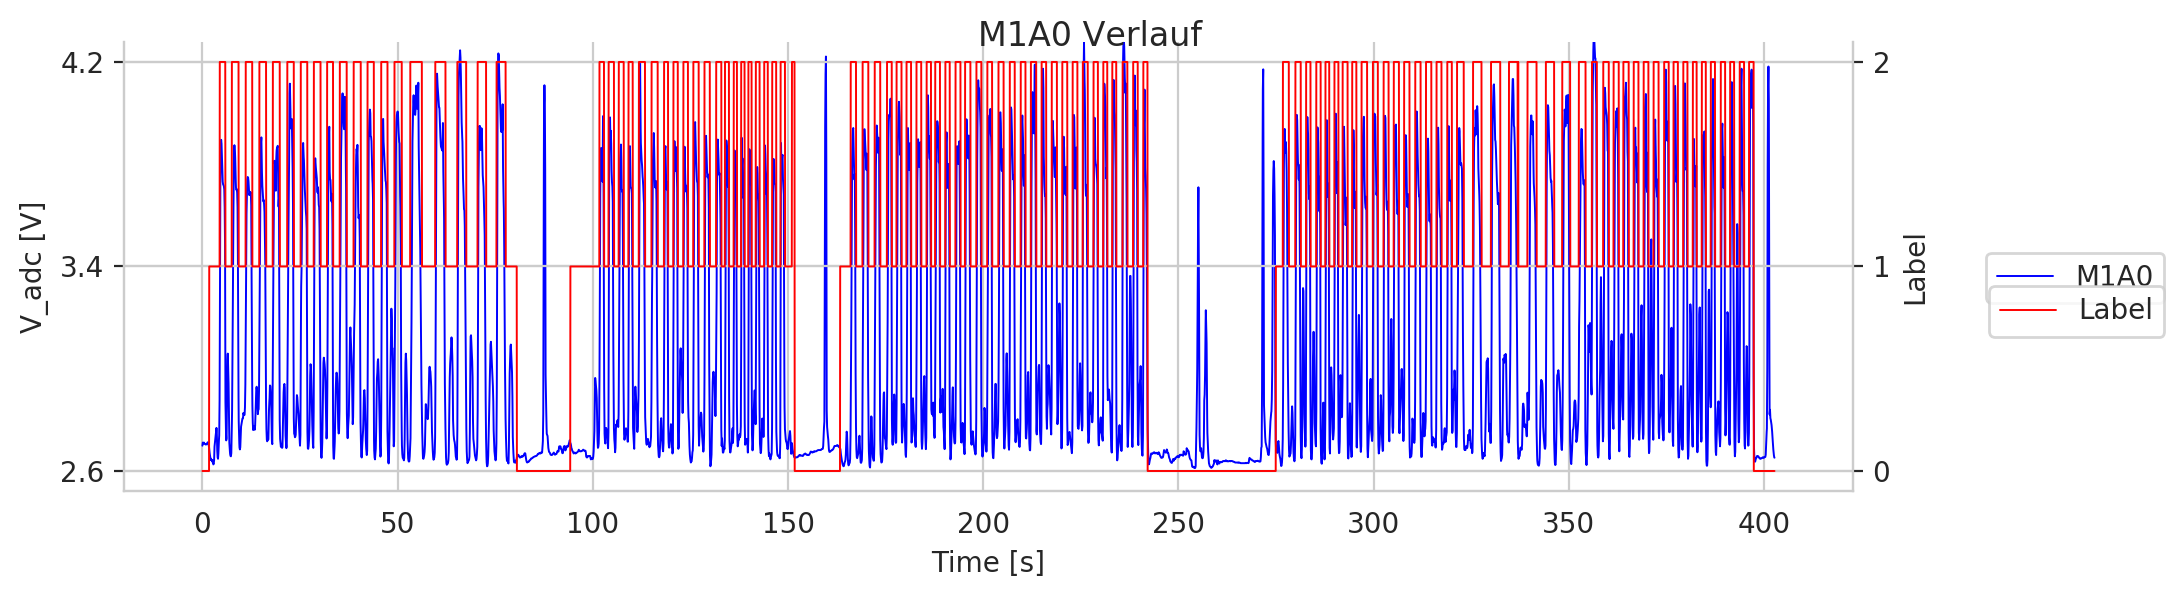

In [67]:
f, ax1 = plt.subplots(figsize=(11, 3), dpi=200, facecolor='w', edgecolor='k')
#fig, ax1 = plt.subplots(1, figsize=(11, 5), dpi=200, facecolor='w', edgecolor='k'),
f.suptitle('M1A0 Verlauf')
ax1.plot(x, sock_data2['M1A0'],'b', label='M1A0',linewidth=0.7, mew=0.1)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('V_adc [V]')
ax1.set_ylim(2.52,4.28)
ax1.set_yticks([2.6,3.4,4.2])
ax2 = ax1.twinx()
ax2.plot(x, np.transpose(yKurven),'r', label='Label',linewidth=0.7, mew=0.1)
ax2.set_ylim(-0.1,2.1)
ax2.set(yticks=([0,1,2]) )
ax2.set_ylabel('Label')
ax1.legend(loc=7,bbox_to_anchor=(0.61, 0.15, 0.57, 0.65), borderaxespad=0)
ax2.legend(loc=7,bbox_to_anchor=(0.61, 0.15, 0.57, 0.5), borderaxespad=0)
#plt.xlim(left=0, right=50)
sns.despine(right=False)
f.tight_layout()
plt.show()

###### Aufteilen der Daten in Trainings und in Testdaten:

    x_train    y_train                  64%
    x_val      y_val                    16%
    x_test     y_test                   20%
    

In [50]:
Y_Kurven_all.shape

(8054, 3)

Auswahl eines Zeitintervals in dem alle Label auftreten für Testdaten.

        Test Daten für ca. 80 s ab 150 s
Ausschneiden und einfügen dieser Testdaten ans Ende der Datenreihe

In [51]:
Y_cut_first_second = Y_Kurven_all[:cut2]
Y_cut_first = Y_cut_first_second[:cut1]
Y_cut_second = Y_cut_first_second[cut1:]
Y_cut_third = Y_Kurven_all[cut2:]

Y_Kurven_all_cut = np.concatenate((Y_cut_third, Y_cut_first, Y_cut_second), axis=0)

In [52]:
Y_Kurven_all_cut.shape

(8054, 3)

In [53]:
y_k_train_val = Y_Kurven_all_cut[:idx_test]
y_k_train0 = y_k_train_val[:idx_val]
y_k_val0 = y_k_train_val[idx_val:]
y_k_test0 = Y_Kurven_all_cut[idx_test:]
#y_k_test0.shape

In [54]:
temp = np.ndarray((1,timesteps,3))
temp.fill(0)
y_k_train = np.ndarray((1,timesteps,3))
y_k_train.fill(0)

for i in range(a):
    for j in range(timesteps):
        for k in range(3):
            temp[0,j,k] = y_k_train0[(j+i*step),k]
    y_k_train = np.concatenate((y_k_train,temp), axis=0)
y_k_train = y_k_train[1:] 

In [55]:
temp = np.ndarray((1,timesteps,3))
temp.fill(0)
y_k_val = np.ndarray((1,timesteps,3))
y_k_val.fill(0)

for i in range(b):
    for j in range(timesteps):
        for k in range(3):
            temp[0,j,k] = y_k_val0[(j+i*step),k]
    y_k_val = np.concatenate((y_k_val,temp), axis=0)
y_k_val = y_k_val[1:] 

In [56]:
temp = np.ndarray((1,timesteps,3))
temp.fill(0)
y_k_test = np.ndarray((1,timesteps,3))
y_k_test.fill(0)

for i in range(c):
    for j in range(timesteps):
        for k in range(3):
            temp[0,j,k] = y_k_test0[(j+i*step),k]
    y_k_test = np.concatenate((y_k_test,temp), axis=0)
y_k_test = y_k_test[1:]  

In [57]:
y_k_train = y_k_train[:(int(y_k_train.shape[0]/batchsize)*batchsize)]
y_k_val = y_k_val[:(int(y_k_val.shape[0]/batchsize)*batchsize)]
y_k_test = y_k_test[:(int(y_k_test.shape[0]/batchsize)*batchsize)]

In [58]:
x_train.shape, x_val.shape, x_test.shape

((5120, 22, 20), (1152, 22, 20), (1536, 22, 20))

In [59]:
y_k_train.shape, y_k_val.shape, y_k_test.shape, a, b, c, idx_val, idx_test

((5120, 22, 3), (1152, 22, 3), (1536, 22, 3), 5133, 1266, 1589, 5155, 6443)

#### Abspeichern der Trainings- Validierungs- und Testdaten der Eingabe und der Zeilwerte der KNNs - 3-Label-Variante

In [60]:
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/3Label/x_train', x_train)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/3Label/x_val', x_val)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/3Label/x_test', x_test)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/3Label/y_k_train', y_k_train)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/3Label/y_k_val', y_k_val)
#np.save('Klassifizierung_NNs/Klassifizierung_Daten/3Label/y_k_test', y_k_test)

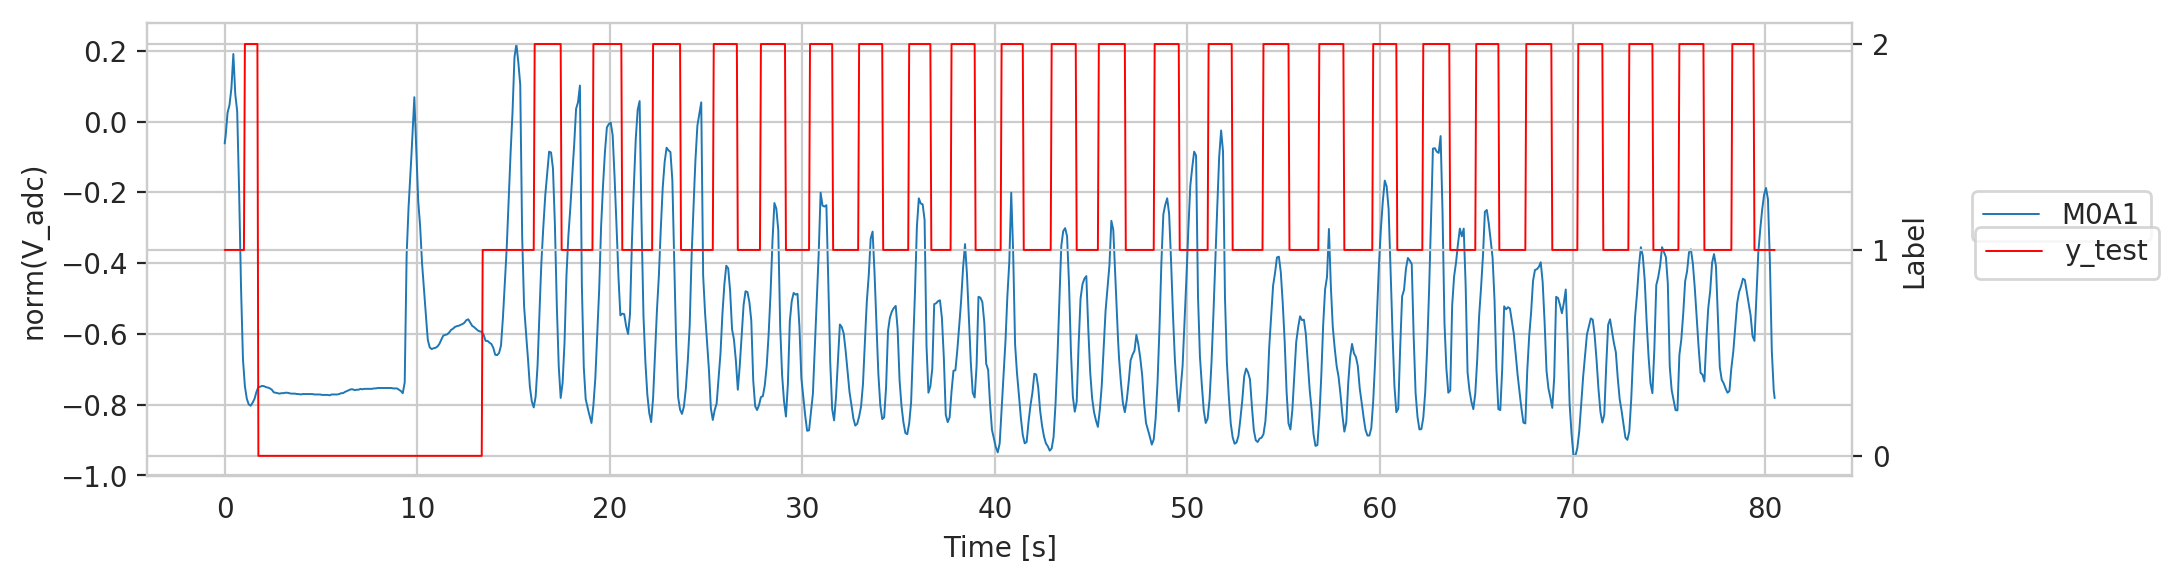

In [66]:
f, ax1 = plt.subplots(figsize=(11, 3), dpi=200, facecolor='w', edgecolor='k')
ax1.plot(np.linspace(0,len(y_k_test0)-1,len(y_k_test0))*0.05,x_test0.iloc[:,0], label='M0A1',linewidth=0.7, mew=0.1)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('norm(V_adc)')
ax2 = ax1.twinx()
ax2.plot(np.linspace(0,len(y_k_test0)-1,len(y_k_test0))*0.05,np.argmax(y_k_test0, axis=1),'r', label='y_test',linewidth=0.7, mew=0.1)
ax2.set(yticks=([0,1,2]) )
ax2.set_ylabel('Label')
ax1.legend(bbox_to_anchor=(0.6, 0.15, 0.575, 0.48), borderaxespad=0)
ax2.legend(bbox_to_anchor=(0.6, 0.15, 0.58, 0.4), borderaxespad=0)
#plt.xlim(left=0, right=500)
plt.show()

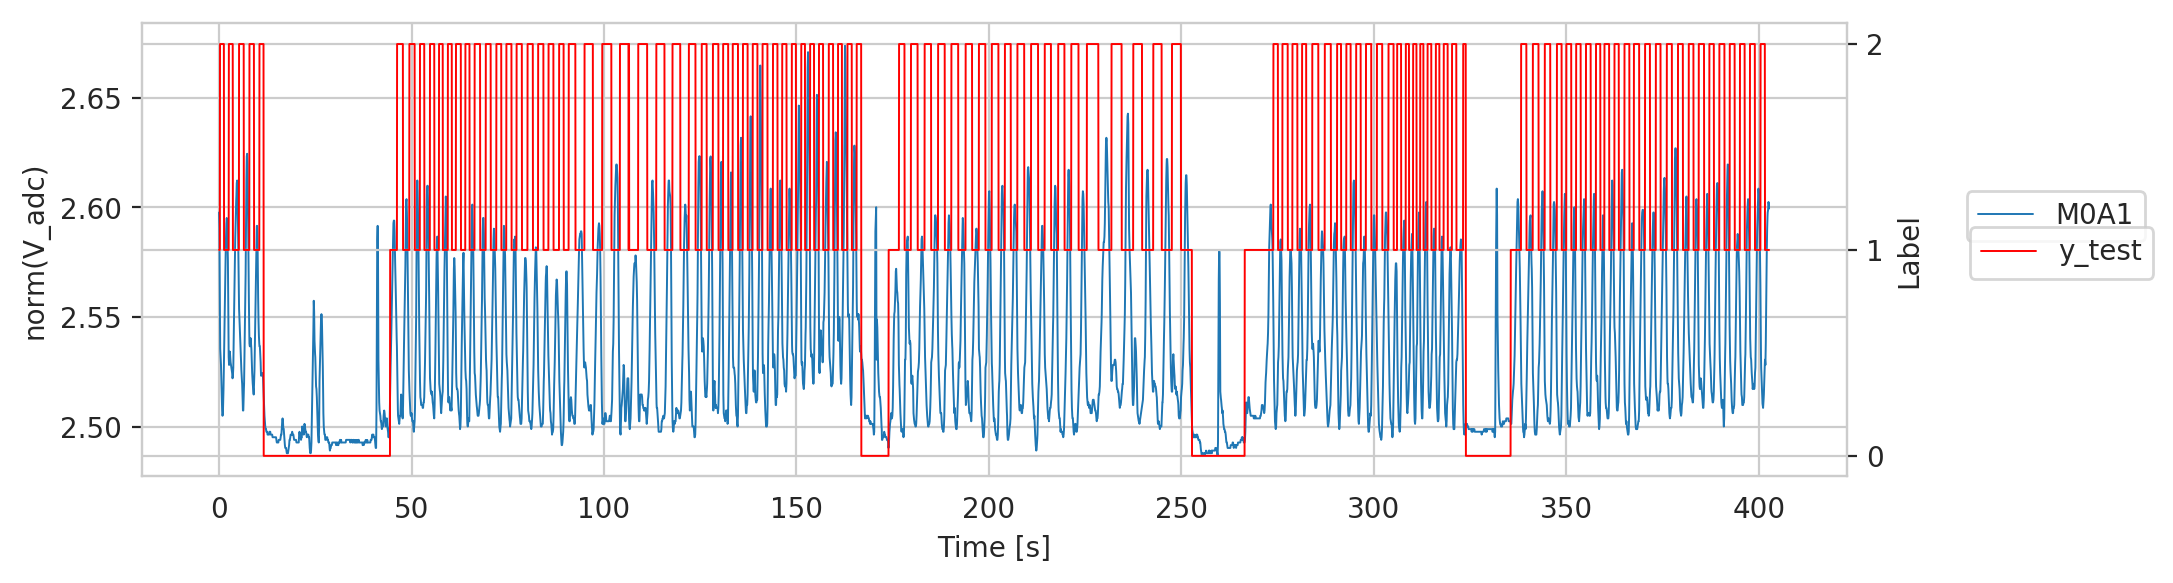

In [62]:
f, ax1 = plt.subplots(figsize=(11, 3), dpi=200, facecolor='w', edgecolor='k')
ax1.plot(np.linspace(0,len(sock_data4)-1,len(sock_data4))*0.05,sock_data4['M0A1'], label='M0A1',linewidth=0.7, mew=0.1)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('norm(V_adc)')
ax2 = ax1.twinx()
ax2.plot(np.linspace(0,len(Y_Kurven_all_cut)-1,len(Y_Kurven_all_cut))*0.05,np.argmax(Y_Kurven_all_cut, axis=1),'r', label='y_test',linewidth=0.7, mew=0.1)
ax2.set(yticks=([0,1,2]) )
ax2.set_ylabel('Label')
ax1.legend(bbox_to_anchor=(0.6, 0.15, 0.575, 0.48), borderaxespad=0)
ax2.legend(bbox_to_anchor=(0.6, 0.15, 0.58, 0.4), borderaxespad=0)
#plt.xlim(left=0, right=500)
plt.show()

In [63]:
np.argmax(y_k_test0, axis=1)

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
y_k_test.shape

(1536, 22, 3)

In [65]:
#sock_data4